# Lab description

This time you have to complete a number of various simple yet more or less
realistic research tasks based on new datasets.

Your tasks are (extensive explanations are given below):

1. Calculate average wages in Saint Petersburg's municipal districts for a given
year, generate corresponding table and map.
2. Using regular expressions, get some insights on businesses registered in
Leningrad Oblast.
3. Complete a function that generates a map with some CHS in its center and
various objects in its surrounding area.
4. Play with functions creation to take a rest.


In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import re

# Part I: Saint Petersburg municipal districts, statistics and geometries

> Your first task is to use the dataset exported directly from GKS to construct
and map the average monthly wages for Saint Petersburg administrative
districts. Note that you are not allowed to download dataset in a different
format which could be more convenient to process in R. Then you have to merge the
resulting dataset with spatial dataset of districts' contours, and to show
districts' differences in wages on a map.
However, as you will see, there are some issues here with spatial data, and
fixing those issues is a part of a task here.

*We will try to import the data with best results possible*.

**Import `./data/gks.spb.average_monthly_wages.csv`**.


In [2]:
spb = pd.read_csv('./data/gks.spb.average_monthly_wages.csv', encoding='windows-1251', engine='python', sep=';(?!\s)', header=1, on_bad_lines='skip')

In [3]:
spb = spb.drop(spb.columns[4], axis = 1)

**Inspect first rows of the dataset and comment what is actually an issue with the
data.**

Данные не структурированы, в строках записаны как показатели, так и наименования муниципальных образований.

**Comment on what regular expression can catch all the separators in the string**

Все сепараторы отличаются от знаков препинания тем, что после них отсутствует пробел.

*Now it is time to remember which years were in those columns. Rename the columns*
*in a "Y20xx" fashion.*


*In addition, empty values in all columns may be a sign of «variable-carrying» row.*
*Subset all rows conforming to that rule and check if this hypothesis is true and*
*print their `X1` column.*


*Ok, it seems that we may use this rule to create a new variable carrying*
*information on a district. Create a new column named `district` and fill*
*it with NA. Then fill it with values of `X1` column for rows where are*
*observations are empty. Then apply any forward NA-filling function*
*(e.g. `zoo::na.locf()`) to fill NA values with previous observations. In the *
*case you use `zoo::na.locf()` consider passing `na.rm = FALSE` argument to*
*guarantee that the result is of the same length as the NA-carrying vector.*


Use console to check that everything looks fine, then drop the rows that
contain information on a district: we don't need them anymore, and they are
now preventing us from tidying the dataset.


In [4]:
spb.reset_index(inplace=True)

In [5]:
spb.columns = ['subindicator', 2017, 2018, 2019, 'district']

In [6]:
def district_parser(df):
    district = ''
    x = list(range(len(df)))
    for i in x:
        if df.iloc[i, 1:].isnull().all():
            district = df.iloc[i, 0]
            df.drop(df.iloc[i, :].name, inplace=True)
            x.pop()
        df.iloc[i, -1] = district
    return df

In [7]:
spb = district_parser(spb)

In [8]:
spb.columns.map(type)

Index([<class 'str'>, <class 'int'>, <class 'int'>, <class 'int'>,
       <class 'str'>],
      dtype='object')

In [9]:
spb.iloc[:, 1:-1] = spb.iloc[:, 1:-1].replace(',','.', regex=True)

In [10]:
spb[[2017, 2018, 2019]] = spb[[2017, 2018, 2019]].astype('float')

In [11]:
spb.dtypes

subindicator     object
2017            float64
2018            float64
2019            float64
district         object
dtype: object

*Now you are ready to make a tidy form of the XXX dataset.*
*Here and everywhere in this lab you are*
*free to use one of the `tidyverse` or `data.table` styles, mix them, use*
*`tidyr` package from time to time etc.*

*Make it tidy. Use «year» for variable name and «avg_wage_mo» for value name.*
*Save resulting dataset to `gks.wages.tidy` variable.*


*Now it is time to make simple transformations:*

- *rename `X1` to "subindicator".*
- *remove "Y" from values in year column and transform year to integer*
- *substitute "," by "." in `avg_wage_mo` column and transform the result to*
*double (`as.numeric()`)*


In [12]:
spb = pd.melt(spb, id_vars=['subindicator', 'district'], value_vars=[2017, 2018, 2019],
        var_name='year', value_name='avg_wage_mo')

In [13]:
spb.head()

,subindicator,district,year,avg_wage_mo
0,Всего по обследуемым видам экономической деяте...,Муниципальные образования Города Санкт-Петербу...,2017,63102.7
1,"Раздел А Сельское, лесное хозяйство, охота, ры...",Муниципальные образования Города Санкт-Петербу...,2017,38939.1
2,Раздел В Добыча полезных ископаемых,Муниципальные образования Города Санкт-Петербу...,2017,283911.8
3,Раздел C Обрабатывающие производства,Муниципальные образования Города Санкт-Петербу...,2017,67637.2
4,"Раздел D Обеспечение электрической энергией, г...",Муниципальные образования Города Санкт-Петербу...,2017,60912.2


*An absence of warnings is a good sign here: we have not lost any numeric value!*
*Now that the dataset is tidy, plot a simple `ggplot` demonstrating average*
*monthly wage by subindicator, in which wage is the x-axis, and*
*subindicator is the y-axis. Use `summarize` from*
*tidyverse or `by` argument in case you prefer `data.table`. Geom should be `col.`*

*Think before you average the wage: try to do some clever averaging that does*
*not allow some of the districts to outweigh other ones. Also, try to make*
*a good-looking chart by means of `theme()` and other `ggplot2` instruments.*


In [14]:
spb_agg = spb.groupby(['subindicator', 'district']).median().reset_index().drop(columns=['year','district']).groupby(['subindicator']).median().reset_index().sort_values(['avg_wage_mo'])

In [15]:
spb_agg

,subindicator,avg_wage_mo
5,Раздел I Деятельность гостиниц и предприятий о...,39132.700
15,Раздел S Предоставление прочих видов услуг,39909.400
10,Раздел N Деятельность административная и сопут...,40122.575
19,"Раздел Е Водоснабжение; водоотведение, организ...",41797.950
17,"Раздел А Сельское, лесное хозяйство, охота, ры...",41957.550
12,Раздел P Образование,49876.500
8,Раздел L Деятельность по операциям с недвижимы...,51690.000
14,"Раздел R Деятельность в области культуры, спор...",51810.800
20,Раздел Н Транспортировка и хранение,54157.100
11,Раздел O Государственное управление и обеспече...,55882.300


In [16]:
spb_list = spb_agg['subindicator'].tolist()

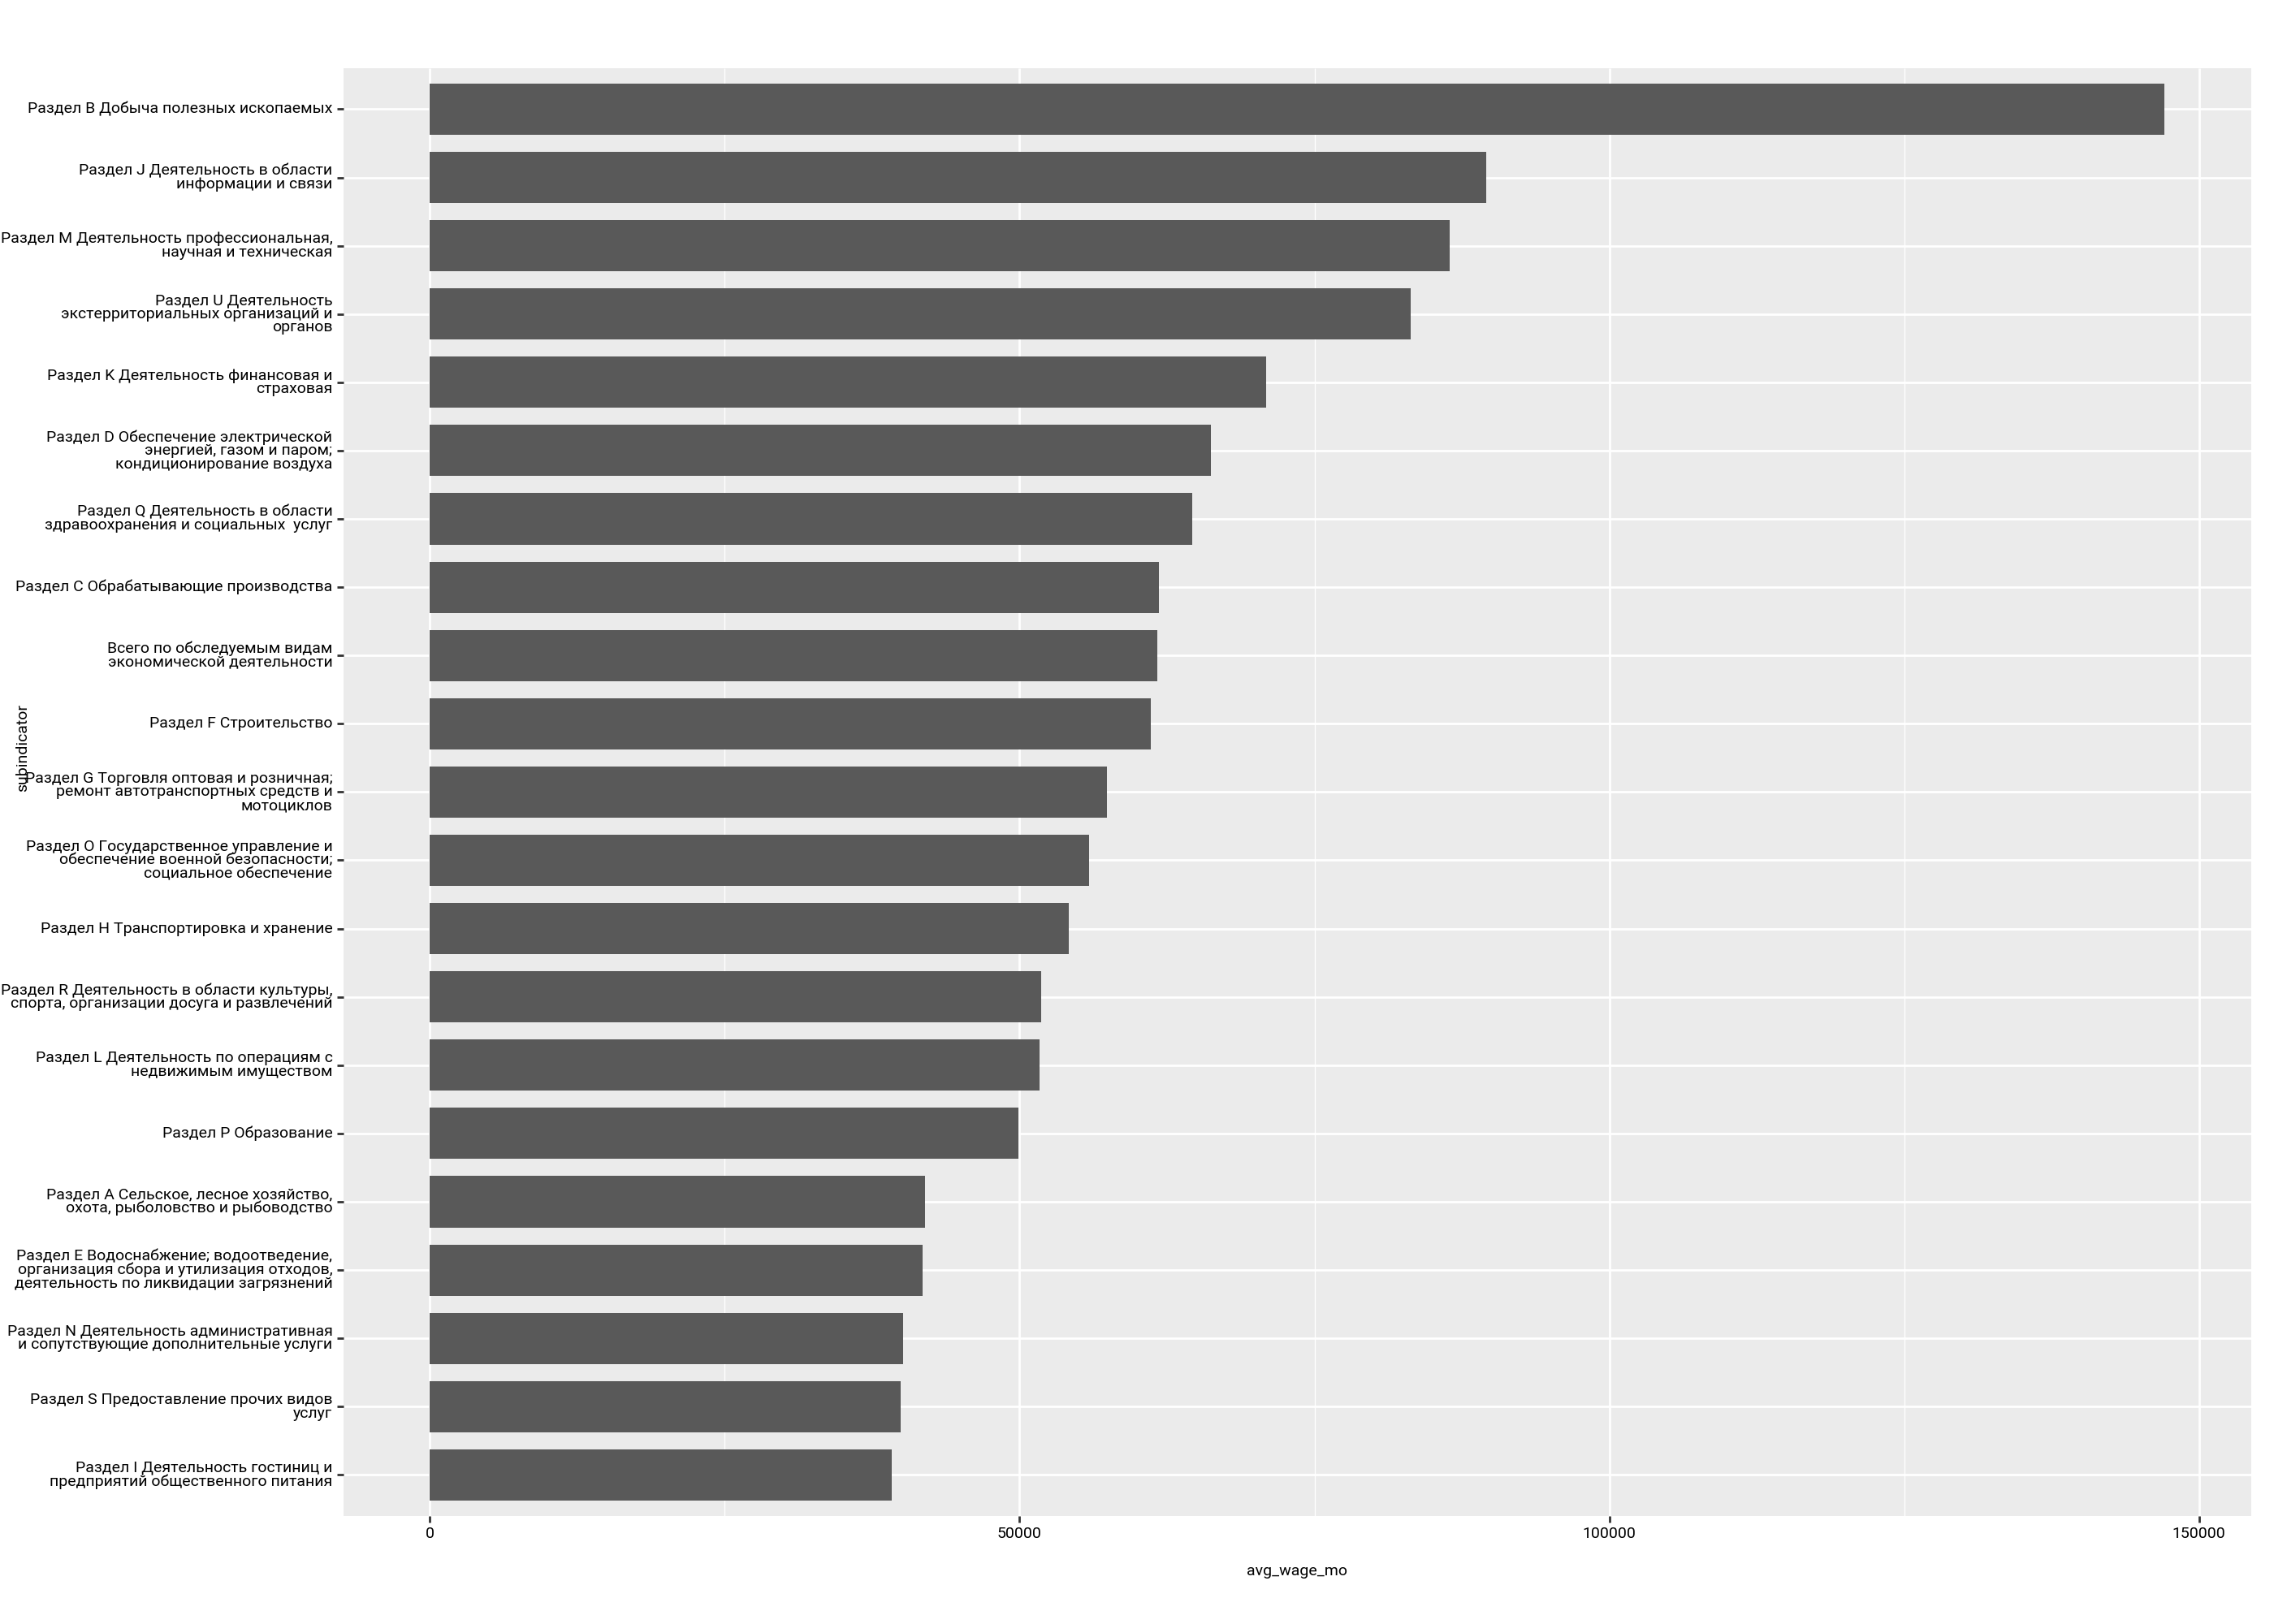

<Figure Size: (1400 x 1000)>

In [17]:
from plotnine import (
    ggplot,
    aes,
    geom_col,
    geom_map,
    facet_grid,
    labs,
    guide_legend,
    guides,
    theme,
    element_text,
    element_line,
    element_rect,
    theme_set,
    theme_void,
    coord_flip,
    scale_color_cmap,
    scale_x_discrete
)

(ggplot(spb_agg, aes(x='subindicator', y='avg_wage_mo'))
 + geom_col(stat='identity', show_legend=False, width=0.75)
 + coord_flip()
 + theme(
     figure_size=(14, 10),
     text=element_text(family='roboto', color='black', size=7, wrap=True)
        )
 + scale_x_discrete(limits=spb_list)
)

*Now you're given a spatial dataset of Saint Petersburg districts.*
*Original data was obtained via the*
*Overpass Turbo using rather simple expression, which has literally one*
*non-trivial string: `relation["addr:region"="Санкт-Петербург"]["admin_level"=8];`.*

*However, for educational purposes, we simulate an environment in which some parts*
*of data may be damaged by geometry simplification. You may try playing with*
*simplification by passing different values of `dTolerance` to the*
*`sf::st_simplify()` function. Here we can see some special properties, which*
*often appear in datasets obtained from WFS/WMS servers.*


In [18]:
import shapely

spb_spatial = gpd.read_file('./data/spb_relations_1.gpkg')

In [19]:
spb_spatial.plot()

<Axes: >

In [20]:
spb_spatial.head()

,name,geometry
0,Колпино,"POLYGON ((30.60119 59.78933, 30.60861 59.77395..."
1,Понтонный,GEOMETRYCOLLECTION (POLYGON ((30.61846 59.7703...
2,Сапёрный,"POLYGON ((30.66325 59.78100, 30.67173 59.77958..."
3,Металлострой,"POLYGON ((30.56312 59.82088, 30.58872 59.80825..."
4,Усть-Ижора,"POLYGON ((30.62283 59.79733, 30.61033 59.79230..."


*That's because of geometry types. Mapview package (and QGIS) fails to visualize*
*objects of type GEOMETRYCOLLECTION. Real-life GIS databases contain such geometries*
*from time to time. A collection may contain geometries of different types; that*
*is especially inconvenient on your stage of data processing, as you have to*
*make a choice to drop such features completely or to select the main geometry*
*type that they represent or to create multiple instances of a single feature,*
*each containing geometry of different type.*

*In our case, however, you deal with a simplest and most common issue: a single*
*geometry is packed into a collection. Detect one or more features that*
*demonstrate such quality by using `st_geometry_type()` and change their geometry*
*to a common type using `st_collection_extract()` function. In real life*
*sometimes it is most efficient to use for loops for that purpose, as it is*
*more or less manual work.*

*You may use `table()` function on a vector of geometry types to find out how*
*many features in your dataset are of type GEOMETRYCOLLECTION.*


In [21]:
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

spb_spatial['geometry'] = [MultiPolygon([feature]) if isinstance(feature, Polygon) \
    else feature for feature in spb_spatial['geometry']]

In [22]:
spb_spatial['geometry'].geom_type.value_counts()

MultiPolygon          110
GeometryCollection      1
Name: count, dtype: int64

In [23]:
spb_spatial.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
spb_spatial['geometries'] = spb_spatial.apply(lambda x: [g for g in x.geometry.geoms], axis=1)

In [25]:
spb_spatial = spb_spatial.explode(column='geometries').drop(columns='geometry').set_geometry('geometries').rename_geometry('geometry')

In [26]:
spb_spatial.plot()

<Axes: >

In [27]:
spb_spatial.set_crs('EPSG:4326', inplace=True).plot()

<Axes: >

*Inspect the dataset using `mapview`. What is the problem here?*

*You can see that everything seems to be fine, but the geometries appear to be*
*too crude. Don't worry, we have an additional file with the same data!*


In [28]:
spb_spatial2 = gpd.read_file('./data/spb_relations_2.gpkg')

In [29]:
spb_spatial2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [30]:
spb_spatial2.plot()

<Axes: >

*You can see that here we have nice geometries, but two districts are missing here,*
*and we have no labels. You are required to create a composite spatial dataset*
*which will consist of fine geometries and districts'names whenever possible.*
*In the case some district does not have a fine geometry, you have to include it into the*
*resulting dataset using a crude geometry.*

*Here we simplify the problem: you can use `st_centroid` to do spatial join*
*between features. In real life you have to do joins based on intersection*
*and then filter out features that are not similar enough to your feature of*
*interest.*

*Assign resulting spatial dataset to the variable with name `spb_spatial`. Start*
*by doing the spatial join.*


In [ ]:
spb1 = spb_spatial.set_geometry(spb_spatial.centroid)

In [ ]:
spb2 = spb_spatial2.set_geometry(spb_spatial2.centroid)
spb2['polys'] = spb_spatial2['geometry']

In [ ]:
spb_spatial3 = spb2.sjoin_nearest(spb1)

*Examine the result using `mapview`. You can see that in one case join failed to*
*help us. You can examine both datasets and set the name for a single feature*
*without joined name attribute by hand.*


*Now add to the dataset all features that do not have a fine geometry provided*
*in the second dataset.*


In [34]:
spb_sptl = spb_spatial3.drop(columns='geometry').set_geometry('polys').rename_geometry('geometry')

In [35]:
spb_sptl.plot()

<Axes: >

*Finally, merge spatial and non-spatial data. Before doing that, drop some*
*observations that have in their district columns the following values:*

- *"Муниципальные образования Города Санкт-Петербурга (города федерального значения)"*
- *"Внутригородские территории  города Санкт-Петербурга"    *


In [36]:
spb.district = spb.district.replace(r'\s+', ' ', regex=True)
spb = spb[(spb.district != 'Муниципальные образования Города Санкт-Петербурга (города федерального значения)') & (spb.district != 'Внутригородские территории города Санкт-Петербурга')]

*Now study both datasets and determine which words should be excluded. Use `gsub`*
*and `stringr::str_trim()` to remove words and trim hanging spaces.*


In [37]:
pd.set_option("max_colwidth", 100)
pd.set_option("display.max_rows", 100)

*Check for the differences between district names in the datasets using `setdiff`*
*function. You may find it convenient to order results alphabetically.*


In [38]:
spb_sptl

,geometry,index_right,name
0,"POLYGON ((30.60119 59.78933, 30.60106 59.78945, 30.60084 59.78955, 30.60083 59.79000, 30.60083 5...",0,Колпино
1,"POLYGON ((30.61846 59.77035, 30.61912 59.77023, 30.61961 59.77006, 30.61983 59.76983, 30.62004 5...",1,Понтонный
2,"POLYGON ((30.66325 59.78100, 30.66322 59.78144, 30.66310 59.78150, 30.66315 59.78154, 30.66319 5...",2,Сапёрный
3,"POLYGON ((30.56312 59.82088, 30.56294 59.82083, 30.56149 59.82051, 30.56056 59.82030, 30.55991 5...",3,Металлострой
4,"POLYGON ((30.62283 59.79733, 30.61498 59.80258, 30.60433 59.80831, 30.59764 59.81200, 30.59588 5...",4,Усть-Ижора
...,...,...,...
104,"POLYGON ((30.28801 59.98967, 30.28639 59.98913, 30.28096 59.98790, 30.27929 59.98755, 30.27771 5...",106,округ Чёрная речка
105,"POLYGON ((29.96534 60.04348, 29.96519 60.04302, 29.96495 60.04266, 29.96457 60.04240, 29.96286 6...",107,Лисий Нос
106,"POLYGON ((30.18055 59.99275, 30.18054 59.99247, 30.18048 59.99242, 30.18061 59.99230, 30.18080 5...",108,округ Лахта-Ольгино
107,"POLYGON ((30.27626 60.03736, 30.27624 60.03732, 30.27619 60.03729, 30.27614 60.03728, 30.27606 6...",109,округ Юнтолово


*As you can see, in addition to usual "е"/"ё" issues, one of the districts*
*changed its name (actually, nearly 4 years ago). Correct that manually and*
*prepare data to be merged.*

*In addition, there is an upper/lowercase differences. You may convert*
*everything to lowercase to fix that.*


In [39]:
spb_sptl['name'] = [i.lower() for i in spb_sptl['name']]
spb['district'] = [i.lower() for i in spb['district']]

In [40]:
spb['name'] = None
spb['geometry'] = None
spb = spb.set_geometry('geometry')

*Run another setdiff to check district names.*

*Now do merge by any merging function you prefer. Assign the result to*
*variable called `spb.sf`. In most cases you have to run the result through*
*`st_sf` after merge just for the class of it to inherit `sf`.*


In [41]:
for i in range(len(spb_sptl)):
    spb.loc[spb.district.str.contains(spb_sptl['name'][i]), 'name']=spb_sptl['name'][i]
    spb.loc[spb.district.str.contains(spb_sptl['name'][i]), 'geometry']=spb_sptl['geometry'][i]

*Finally, create a map similar to the ggplot above: map average wage per month,*
*averaged by year, by district, only for subindicatior*
*«Всего по обследуемым видам экономической деятельности».*

*Show the spatial distribution of that variable created using `mapview` function. Use*
*Pantone Color of the Year 2006 for polygon's contours (consult with* *https://www.rdocumentation.org/packages/mapview/versions/2.9.0/topics/mapView to find*
*which attribute sets color for lines). Use `viridisLite::inferno` color palette*
*(look for examples in documentation, StackOverflow may also be useful here).*


In [42]:
spb_vis = spb[spb['subindicator']=='Всего по обследуемым видам экономической деятельности']
spb_vis = spb_vis[spb_vis['geometry'] != None]
spb_vis = spb_vis.drop(columns='name').groupby(['district', 'subindicator', 'geometry']).median().reset_index().set_geometry('geometry').set_crs('EPSG:4326', inplace=True)

In [43]:
spb_vis.explore(column='avg_wage_mo', scheme="equalinterval", k=5)

In [44]:
# import folium
# from shapely import geometry
# from folium.plugins import MarkerCluster
# import matplotlib.pyplot as plt
# import mapclassify
# from folium.plugins import MousePosition
# from folium.plugins import Fullscreen
# from folium.plugins import Search
# from folium.plugins import MiniMap

In [45]:
# import branca
# colormap = branca.colormap.LinearColormap(colors=['cyan', 'green', 'yellow', 'orange', 'red'],
#                                           vmin=0, vmax=120000, 
#                                           caption='Median wage monthly by 3 years, rub')

In [46]:
# spb_json = spb.drop(columns=['subindicator', 'year']).to_json()

In [47]:
# m = folium.Map(location=[59.942249, 30.314476], zoom_start=15,  tiles='OpenStreetMap', control_scale=True)

In [48]:
# for _, r in spb.iterrows():
#     sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
#     geo_j = sim_geo.to_json()
#     geo_j = folium.GeoJson(data=geo_j, name=(r["district"]), style_function=lambda x: {"fillColor": colormap(r['avg_wage_mo'])}, show=False)
#     folium.Tooltip(r["district"]).add_to(geo_j)
#     geo_j.add_to(m)

*If you see some patterns on which you have something to say, comment here on*
*your insights why the variable is distributed in such a way.*

# Part II: Firms registered in Leningrad Oblast

**Import `./Data/LO_ogrn_with_coords.xlsx`. You may find it convenient to convert**
**it to the `data.table` or `tibble` format.**


In [49]:
lo_ogrn = pd.read_excel('./data/LO_ogrn_with_coords.xlsx')

In [50]:
lo_ogrn.head()

,ОГРН,Название,Адрес,Статус,ОКВЕД код,ОКВЕД описание,Среднесписочная численность работников\n ( -1 = неуказано),v2016,v2015,v2014,...,s2012,p2016,p2015,p2014,p2013,p2012,url,yandex.address,lon,lat
0,1020202871700,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АСПЕКТ""","188502, Ленинградская обл, деревня Горбунки, район Ломоносовский, 2 -, -",Ликвидировано,45.31.1,"Торговля оптовая автомобильными деталями, узлами и принадлежностями, кроме деятельности агентов",-1,0,0,0,...,0,0,0,0,0,0,https://zachestnyibiznes.ru/company/ul/1020202871700_0276071087_OOO-ASPEKT,"Ленинградская область, Ломоносовский район, Горбунковское сельское поселение, деревня Горбунки, 2",59.815776,29.987121
1,1020601371922,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""СЕРДОЛИК""","187000, Ленинградская обл, город Тосно, район Тосненский, проспект Ленина, дом 71, ОФИС 24",В стадии ликвидации,46.47,"Торговля оптовая мебелью, коврами и осветительным оборудованием",-1,0,0,771700000,...,0,0,0,53400000,72700000,0,https://zachestnyibiznes.ru/company/ul/1020601371922_0607001693_OOO-SERDOLIK,"Ленинградская область, Тосненское городское поселение, Тосно, проспект Ленина, 71",59.539669,30.878636
2,1021000510684,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""САТ""","188320, Ленинградская обл, город Коммунар, район Гатчинский, переулок Транспортный, дом 1 ЭТАЖ Ц...",В стадии ликвидации,68.20.2,Аренда и управление собственным или арендованным нежилым недвижимым имуществом,2,2022800000,9501800000,17893400000,...,2740800000,2466600000,1438300000,7644400000,6365200000,2328700000,https://zachestnyibiznes.ru/company/ul/1021000510684_1001133397_OOO-SAT,"Ленинградская область, Гатчинский район, Коммунар, Транспортный переулок",59.622114,30.396151
3,1021000536578,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ПРЕСТИЖ-ПЛЮС""","187602, Ленинградская обл, город Пикалево, район Бокситогорский, шоссе Спрямленное, 5",Ликвидировано,80.41,Обучение водителей транспортных средств,-1,0,0,0,...,0,0,0,0,0,0,https://zachestnyibiznes.ru/company/ul/1021000536578_1001085954_OOO-PRESTIGh-PLYuS,"Ленинградская область, Бокситогорский район, Пикалёвское городское поселение, Пикалёво, Спрямлён...",59.516738,34.188685
4,1021000543838,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""НОВАЯ МОДЕЛЬ""","188653, Ленинградская обл, деревня Вартемяги, район Всеволожский, шоссе Приозерское, 121-а, СЕКЦ...",Ликвидировано,70.20,Сдача внаем собственного недвижимого имущества,-1,0,0,0,...,0,0,0,0,0,0,https://zachestnyibiznes.ru/company/ul/1021000543838_1001136831_OOO-NOVAYa-MODELY,"Ленинградская область, Всеволожский район, Агалатовское сельское поселение, деревня Вартемяги, П...",60.182090,30.321545


**Your task is to calculate various statistical indicators. Start by constructing
number of **consumer's co-operatives** by tax inspectorate.**

- *You may find it useful to consult with Wikipedia's page on how you may obtain*
*info on tax inspectorate from the dataset. Please note that directorate id is*
*non-unique countrywise.*
- *It is advised to inspect the dataset before you fix your assumption on how to*
*filter consumer's co-operatives from data.*
- *For regex pattern matching you perhaps need `%like%` from `data.table` or *
`stringr::str_detect()`.*


In [51]:
coop_by_tax = lo_ogrn['ОГРН'].groupby(lo_ogrn['ОГРН'].astype(str).str[3:7]).count()
coop_by_tax

ОГРН
0105      1
0202      1
0280      1
0327      1
0411      1
       ... 
8900      1
8904      3
9102      2
9847    324
9848     28
Name: ОГРН, Length: 307, dtype: int64

*Proceed by finding which tax inspectorate has most firms in operating state*
*(according to the dataset). Please, count only those firms that were initially *
*registered in Leningrad Oblast. For example, MSRN (ОГРН) #1020202871700*
*appears to be initially registered in Alsheyevsky District, Bashkortostan.*


In [52]:
max_op = lo_ogrn[lo_ogrn['Статус']=='Действующее предприятие']['ОГРН'].groupby(lo_ogrn['ОГРН'].astype(str).str[3:7]).count()
max_op.sort_values(ascending=False)

ОГРН
4704    6373
4700    5722
4701    3686
4703    2499
4705    1798
        ... 
5194       1
0280       1
5105       1
5102       1
0105       1
Name: ОГРН, Length: 187, dtype: int64

*Examine and list top regions that contribute to the list of firms in operating*
*state.*


In [53]:
max_reg = lo_ogrn[lo_ogrn['Статус']=='Действующее предприятие']['ОГРН'].groupby(lo_ogrn['ОГРН'].astype(str).str[3:5]).count()
max_reg.sort_values(ascending=False)

ОГРН
47    27309
78     1683
98      186
77       74
35       16
53       15
51       14
50       10
39        9
60        8
54        6
23        6
43        6
16        5
29        5
10        5
55        4
76        4
24        4
64        3
69        3
61        3
11        3
34        3
52        2
22        2
66        2
68        2
33        2
31        2
26        2
91        1
03        1
74        1
73        1
70        1
71        1
72        1
63        1
75        1
04        1
59        1
57        1
56        1
05        1
02        1
45        1
41        1
38        1
37        1
36        1
32        1
25        1
21        1
18        1
01        1
Name: ОГРН, dtype: int64

*Finally, use map to show all firms with more than RUB 4B in revenue and more than*
*30% YoY increase in profit in year 2016. You can make some calculations*
*on-the-fly using pipes or create new YoY variable at first and then plot it.*
*You may use any of the frameworks you prefer: mapview, ggplot etc.*

*Describe in one sentence, what are the news generated by the leader of this*
*«rating» in December 2019.*

**Bankruptcy**


In [54]:
gdf = gpd.GeoDataFrame(
    lo_ogrn[['ОГРН', 'Название', 'Адрес', 'Статус', 'ОКВЕД код', 'ОКВЕД описание', 'v2016', 'p2016', 'p2015']], geometry=gpd.points_from_xy(lo_ogrn['lat'], lo_ogrn['lon']))

In [55]:
gdf = gdf[(gdf['v2016'] > 4000000000) & ((gdf['p2016']/gdf['p2015'])>1.3)]
gdf = gdf.sort_values(['v2016'], ascending=False)

In [56]:
gdf.set_crs('EPSG:4326', inplace=True).explore()

# Part III: VK geophotos and spammers

> Your task here is to use regular expressions to filter spam from geotagged
photos uploaded to the VK social network. There are various ways to define
spam, but generally we want to exclude people who post too much, upload tons of
nearly identical photos. That is because on later stages we often construct heatmaps
showing photos distribution in an area of interest, and spam may create
imbalances leading to incorrect conclusions from the data.

**Import `db_photos.Surgut_District.RDS` dataset to the environment. Assign it
to the variable «db_photos».**

**Не открывается!!**


In [57]:
# import pyreadr

# result = pyreadr.read_r('./data/db_photos.Surgut_District.Rds')

In [58]:
# db_photos <- readRDS("./Data/db_photos.Surgut_District.RDS")

*You have to create «is_spam» column which has to be filled with zeroes for photos*
*that you think are not spam and with ones for spam photos.*

You can see a codebook for the dataset here:

- https://vk.com/dev/objects/user
- https://vk.com/dev/objects/photo

**Print statuses for top-10 profiles (by the number of photos in the dataset).**


In [59]:
# db_photos$is_spam <- 0

*Do what you think is best in terms of results/effort ratio to filter spam*
*using only status variable. To simplify things, let's suppose that if we*
*qualify some profile as a spam, we throw away (or just do not use) all of its*
*photos.*

*You may mark spam by absolute photos count, or by appearance of some phrase in*
*`status`. Example to study statuses is given below in comment*
*(calculation may take up to 30 seconds).*


In [60]:
# tmp$status %>% strsplit(" ") %>% unlist %>% table %>% .[order(.)] %>% tail(100)

**Describe what had you come up with. Show some statistics on spam photos and**
**profiles**.

**Take a look at the `date` column.**


*Guess what you should do here to have date in a convenient format, or just consult with the hints section.*


**Bonus tasks**

- Export data leaving only the profile id, date and spam flag (if you had not decided to
remove spam rows from the data completely on a previous stage) columns. Do that such that the format of export can be opened in kepler.gl.
- Produce a kepler.gl heatmap in any of style you prefer. Save it and upload with
the lab.
- Try to think of additional ways of spam filtering. Describe in text below,
what are your ideas. Hint: you may find something useful in datetime, geometries
and photo URLs. Please note, that in this case we are not obliged to mark *all*
photos of somebody as spam, -- we may be more flexible.

# Part IV: functions

## Warm-up

Create an `if` statement that checks if 10 is in the range from 1 to 100 and prints out the confirmation that 10 is indeed in this range. Use `10 %in% 1:100` - `%in%` is a comparison operator, that checks if the value(s) of the vector to the left from the operator matches any of the value(s) of the vector to the rigth of the operator.


In [60]:
10 in range(1, 100)

True

Create a function named `isin()` using the `if` statement above. The function should take two arguments: (1) an argument instead of `10` and (2) another argument instead of `1:100`.


In [61]:
def isin(x, y):
    z = x in range(int(y.split(':')[0]), int(y.split(':')[1]))
    return z

Test that function three times by calling it with different sets of arguments. For example: `isin(9, 4:15)`.


In [62]:
isin(9, '4:15')

True

Create a function named `product_then_power()`. This function should have three arguments. First and second arguments are the two numbers that you need to find the product of, and the third arguemnt is the power, to which the product should be raised. Make the default value of the third argument such that by default you get the product squared.


In [63]:
def product_then_power(x, y, z=2):
    return (x*y)**z

Test that function three times by calling it with different sets of arguments. For example: `product_then_power(2, 2, 4)`.


In [64]:
product_then_power(2, 2, 4)

256

In [65]:
product_then_power(3, 6)

324

In [66]:
product_then_power(1000, 100000)

10000000000000000

Copy the your function from previous task and modify it to have an `if` condition. Check if the power arguemnt is more than 10.
If it is more than 10, instead of finding the product of two arguments and raising it to the power, print a message with a warning, that rasing to a power larger than 10 may be too slow and crash the computer. If the power argument is less or equal to 10, proceed with finding the product and raising it to power. Return the result.


In [67]:
def product_then_power2(x, y, z=2):
    if z>10:
        print ('Warning! COMPUTER KAPUT!!')
    else:
        return (x*y)**z

Test that function three times by calling it with different sets of arguments. For example: `product_then_power(2, 2, 12)`.


In [68]:
product_then_power2(2, 2, 12)

Warning! COMPUTER KAPUT!!


*That is it, you've made it. Congratulations!*

# Hints

- Date is encoded in Unix Time. Read Wikipedia page. Standard R functions
that convert dates to inner date format work here flawlessly, if you specify
an epoch.